# Imports

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =  (8,6)
#plt.rcParams["figure.figsize"] =  plt.rcParamsDefault["figure.figsize"]
import numpy as np
import pandas as pd
import os
import inspect
from scipy.optimize import curve_fit
from scipy.special import ellipk as K1
from scipy.special import ellipe as K2 #Complete elliptic integral of the first kind
from scipy.stats import chi2

In [13]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "data_corr_testing")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
datas= []
corrs= []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)

# Analytic Calculations

In [14]:
T_c_analytic = 2/np.log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model
ln_T_c_analytic = np.log(T_c_analytic)

def get_E_mean_analytic(T):
    """Calculate the mean energy for the 2D Ising model at temperature T."""
    assert (T >= 0).all(), "Temperature is negative"
    sinh_T = np.sinh(2/T)
    cosh_T = np.cosh(2/T)
    tanh_T = np.tanh(2/T)
    #kappa = 2*sinh_T/cosh_T**2
    kappa = 2*tanh_T/cosh_T #Numerically more stable?
    ellip_int = K1(kappa)
    return -2*tanh_T-(sinh_T**2-1)/(sinh_T*cosh_T)*(2/np.pi*ellip_int-1)

def get_M_abs_analytic(T,B=None): #Absolute value because of spontaneous symmetry breaking
    assert (T >= 0).all(), "Temperature is negative"
    if B is not None:
        assert (B == 0).all(), "Expression only valid for B = 0"
    M_abs_inner = 1-np.sinh(2/T)**-4
    M_abs = np.where(T>=T_c_analytic,0,np.sign(M_abs_inner)*np.abs(M_abs_inner)**(1/8)) #Note continuity at T = T_c_analytic
    return M_abs

def get_cV_analytic(T):
    assert (T >= 0).all(), "Temperature is negative"
    b = 2/T #Thermodynamic beta up to a multiplicative constant
    sinh_b = np.sinh(b)
    cosh_b = np.cosh(b)
    tanh_b = np.tanh(b)
    kappa_b = 2*tanh_b/cosh_b #Numerically more stable?
    K1_int = K1(kappa_b)
    K2_int = K2(kappa_b)
    K1_prime =  (K2_int/(1-kappa_b**2)-K1_int)/kappa_b 
    zero_term = sinh_b**-2
    first_term = -(sinh_b**-2+2*cosh_b**-2)*(2/np.pi)*K1_int
    second_term = 4/np.pi*(sinh_b**2-1)**2/(sinh_b*cosh_b**4)*K1_prime
    cV_analytic = -b**2/2 * (zero_term + first_term + second_term)
    return cV_analytic

def get_chi_analytic(T): #Need partial derivative of M with respect to B
    assert (T >= 0).all(), "Temperature is negative"
    return 0

# Fitting

In [15]:
#Models for fitting
def power_law_fit(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( np.abs(t)** crit_exp)

def power_law_exp_decay_fit(d, R_0, eta, d_c, xi):
   return np.where(d>d_c,R_0 * np.exp(d/-xi),R_0*d_c**eta*d**(-eta)* np.exp(d_c/-xi)) 

def linearized_power_law_fit(ln_X, k, X_c, crit_exp):
    return  np.log(k) + crit_exp * (np.log(np.exp(ln_X)-X_c)-np.log(X_c))

#Returns bounds as formatted for curve_fit
#[(L1,U1),(L2,U2),...(LN,UN)] to ([L1,L2,...,LN],[U1,U2,...,UN])
def to_tuple(bounds: list):
  lower = [b[0] for b in bounds]
  upper = [b[1] for b in bounds]
  return (lower,upper)

In [16]:
def fit(fitting_model, X, X_c, Y_mean, Y_std, expected_crit_exp = 1.0,  from_above = True, print_summary = True, maxfev=10000):
    assert fitting_model is not None, "No fitting model provided"
    if fitting_model is power_law_fit:
        bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp  
        param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    elif fitting_model is power_law_exp_decay_fit:
        bounds = to_tuple([(0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf)])  #Bounds for R_0, eta, d_c, xi
        param_ests = [1, 1, 1, 1] #Initial values for R_0, eta, d_c, xi
    else:
        raise ValueError("Unsupported fitting model provided")
    
    if X_c is not None:
        if from_above: #Only use X data greater than or equal to X_c
            X_filt = X[X >= X_c]
            Y_mean_filt = Y_mean[X >= X_c]
            Y_std_filt = Y_std[X >= X_c]             
        else: #Only use X data less than or equal to X_c
            X_filt = X[X <= X_c]
            Y_mean_filt = Y_mean[X <= X_c]
            Y_std_filt = Y_std[X <= X_c]
    else:
        X_filt = X
        Y_mean_filt = Y_mean
        Y_std_filt = Y_std

    popt, pcov = curve_fit(fitting_model, X_filt, Y_mean_filt, sigma=Y_std_filt, p0=param_ests,bounds=bounds, maxfev=maxfev)

    Y_mean_filt_fit = fitting_model(X_filt,*popt)      
    Y_mean_filt_res = Y_mean_filt - Y_mean_filt_fit
    Y_mean_filt_norm_res = Y_mean_filt_res/Y_std_filt
    N_filt = len(Y_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(Y_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    
    pte = chi2.sf(chi_squared, degrees_of_freedom) #p-value for the fit
    param_errs = np.sqrt(np.diag(pcov))

    param_names = list(inspect.signature(fitting_model).parameters.keys())[1:]    
    param_text = [f"{name} = {param:.2f} ± {err:.2f}" for name, param, err in zip(param_names, popt, param_errs)]
    param_text = "\n".join(param_text)
    chi_squared_text = r'$\chi^2_{\nu} = $'+f"{reduced_chi_squared:.2f}"
    pte_text = r'$p = $'+f"{pte:.2f}"

    if print_summary:
        print(f"Fitting model: {fitting_model.__name__}")
        print(f"Fitting parameters:\n{param_text}")
        print(f"Expected critical exponent: {expected_crit_exp:.2f}")
        print(f"Covariance matrix:\n{pcov}")        
        print(f"Reduced chi squared: {reduced_chi_squared:.2f}")  
        print(f"Probability to exceed: {pte:.2f}")  

    legend_text = "Fit"+"\n"    
    legend_text += f"{chi_squared_text}, {pte_text}"

    return popt, pcov, X_filt, Y_mean_filt_norm_res, legend_text   

## Depracated due to fit

In [17]:
'''
def T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):
    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    
    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp
    if from_above: #Approach critical temperature from above
        T_filt = T[T >= T_c_analytic]
        X_mean_filt = X_mean[T >= T_c_analytic]
        X_std_filt = X_std[T >= T_c_analytic]                
    else: #Approach critical temperature from below
        T_filt = T[T <= T_c_analytic]
        X_mean_filt = X_mean[T <= T_c_analytic]
        X_std_filt = X_std[T <= T_c_analytic] 

    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)

    X_mean_filt_fit = power_law_fit(T_filt,*popt)      
    X_mean_filt_res = X_mean_filt - X_mean_filt_fit
    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt
    N_filt = len(X_mean_filt_norm_res) #Number of points used for the fit
    num_constraints = len(popt)
    degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit
    chi_squared = np.sum(np.square(X_mean_filt_norm_res))
    reduced_chi_squared = chi_squared / degrees_of_freedom    

    if print_summary:
        print(f"Reduced chi squared (fit): {reduced_chi_squared}")
    return popt, pcov, X_mean_filt_norm_res   
'''

'\ndef T_fit(X_mean, X_std, expected_crit_exp = 1.0, from_above = True, print_summary = True):\n    bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    \n    param_ests = [1, T_c_analytic, expected_crit_exp] #Initial values for k, T_C, crit_exp\n    if from_above: #Approach critical temperature from above\n        T_filt = T[T >= T_c_analytic]\n        X_mean_filt = X_mean[T >= T_c_analytic]\n        X_std_filt = X_std[T >= T_c_analytic]                \n    else: #Approach critical temperature from below\n        T_filt = T[T <= T_c_analytic]\n        X_mean_filt = X_mean[T <= T_c_analytic]\n        X_std_filt = X_std[T <= T_c_analytic] \n\n    popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)\n\n    X_mean_filt_fit = power_law_fit(T_filt,*popt)      \n    X_mean_filt_res = X_mean_filt - X_mean_filt_fit\n    X_mean_filt_norm_res = X_mean_filt_res/X_std_filt\n    N_filt = len(X_me

# Single CSV Calculations and Plotting

## Single CSV Calculations

In [18]:
#Settings for the analysis
selected_trial = -1 #Particular trial to analyze (0-indexed)

#Extract data from pandas DataFrame
data_selected_trial = datas[selected_trial]
corr_selected_trial = corrs[selected_trial]
T, E_mean, E_std, M_mean, M_std= data_selected_trial.T.to_numpy()
corr_data = corr_selected_trial.T.to_numpy()
T_corr = corr_data[0]
assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
R_data = corr_data[1:]
R_mean_matrix, R_std_matrix = np.array([R_data[i] for i in range(0,len(R_data),2)]), np.array([R_data[i] for i in range(1,len(R_data),2)])

cV = np.square(E_std)/np.square(T) #In units where k_B = 1
chi = np.square(M_std)/T #In units where k_B = 1
#cV_mean will need to come from combined best estimate: average of cV over CSVs (weighted by cV itself because this is the best estimate for the error of each cV?)
#cV_std will need to come from the standard error of standard deviation
#Same for chi_mean, chi_std

N = len(T) #Number of points in the data
def get_ln_std(X_mean, X_std, use_asymetric_error=True):
    if use_asymetric_error: #Asymmetric error handling
        ln_X_std_lower = np.abs(np.log(X_mean-X_std)) 
        ln_X_std_upper = np.abs(np.log(X_mean+X_std))
        ln_X_std = [ln_X_std_lower, ln_X_std_upper] 
    else:
        ln_X_std = X_std / X_mean  # Propagated error (necessarily symmetric)
    return ln_X_std

In [19]:
def create_plot(X, X_symbol=r"?", X_name=r"???", X_c = None, X_c_symbol = None, Y_mean=None, Y_std=None, Y_symbol=r"?", Y_name=r"???", get_Y_analytic=None, log_plot = True, fitting_model=None, expected_crit_exp = 1.0, from_above=True):   
    #Error handling
    assert Y_mean is not None, "No vertical data given"
    if Y_std is None: #No error is given
        Y_std = np.zeros_like(Y_mean)
        with_errorbar = False
    else: #Check if error is identically 0
        with_errorbar = not (Y_std == np.zeros_like(Y_std)).all() 
    if not with_errorbar:
        print("*Proceeding assuming no error (unphysical)")
    if X_c_symbol is None:
        X_c_symbol = X_symbol     

    if fitting_model is not None: #Work in progress: need to be careful with signs        
        popt, pcov, X_fit, Y_mean_norm_res_fit, fit_legend_text=  fit(fitting_model, X, X_c, Y_mean, Y_std, expected_crit_exp=expected_crit_exp, from_above=from_above) 
             
    if get_Y_analytic is not None:
        X_min, X_max = np.min(X), np.max(X)
        X_analytic = np.linspace(X_min, X_max, 1000)
        Y_mean_analytic = get_Y_analytic(X_analytic) #T_analytic is of high spatial frequency to produce a smooth curve
    else:
        X_analytic = None
        Y_mean_analytic = None

    if fitting_model is not None:
        X_fit_min, X_fit_max = np.min(X_fit), np.max(X_fit)
        X_fit_smooth = np.linspace(X_fit_min, X_fit_max, 1000) #X_fit_smooth is of high spatial frequency to produce a smooth curve
        Y_mean_fit = fitting_model(X_fit_smooth, *popt)
    else:
        X_fit_smooth = None
        Y_mean_fit = None

    if log_plot: #Calculations specific and plotting labels specific to using log plot
        ln_X_fit = np.log(X_fit)
        ln_X = np.log(X)
        if X_c is not None:
            ln_X_c = np.log(X_c)
        ln_Y_mean = np.log(Y_mean)
        ln_Y_std = get_ln_std(Y_mean, Y_std)

        if get_Y_analytic is not None or fitting_model is not None: #If present, get high density ln_X called ln_X_smooth                       
            ln_X_smooth = np.linspace(np.log(X_min), np.log(X_max), 1000)
        else:
            ln_X_smooth = None

        if get_Y_analytic is not None:
            ln_X_analytic = np.linspace(np.log(X_min), np.log(X_max), 1000)
            ln_Y_mean_analytic = np.log(get_Y_analytic(np.exp(ln_X_smooth)))
        else:
            ln_X_analytic = None
            ln_Y_mean_analytic = None

        if fitting_model is not None:
            ln_X_fit_smooth = np.linspace(np.log(X_fit_min), np.log(X_fit_max), 1000)
            ln_Y_mean_fit = np.log(fitting_model(np.exp(ln_X_smooth), *popt))
        else:
            ln_X_fit_smooth = None
            ln_Y_mean_fit = None            
            
        using = [ln_X,ln_X_analytic, ln_X_fit_smooth,ln_X_c, ln_Y_mean, ln_Y_std, ln_Y_mean_analytic, ln_Y_mean_fit]
        X_label = f'$ln({X_symbol})$'
        Y_label = f'$ln({Y_symbol})$'
    else: #Calculations specific and plotting labels specific to non log plots     
        using = [X,X_analytic, X_fit_smooth,X_c,Y_mean, Y_std, Y_mean_analytic, Y_mean_fit] #No analytic curve for non-power-law fits
        X_label = f'${X_symbol}$'    
        Y_label = f'${Y_symbol}$'    
    fit_ax = None
    if get_Y_analytic is not None: #Calculations and plotting specific to having an analytic model
        #Residual calculations
        Y_mean_res_analytic = Y_mean - get_Y_analytic(X)
        Y_std_res_analytic = Y_std
        Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std
        Y_std_norm_res_analytic = 1 #Always 1 since X_std_norm_res_analytic = X_std_res_analytic / X_std = 1

        #Goodness of fit to analytic model
        degrees_of_freedom_analytic = N #Relies on global variable in cell above
        chi_squared_analytic= np.sum(np.square(Y_mean_norm_res_analytic)) 
        reduced_chi_squared_analytic = chi_squared_analytic / degrees_of_freedom_analytic     
        print(f"Reduced chi squared (analytic): {reduced_chi_squared_analytic}")

        #Plotting specific to having an analytic model
        if fitting_model is not None:
            fig, axs = plt.subplots(3,1, constrained_layout=True, sharex=True, height_ratios=[2, 1, 1])  
            fit_ax = axs [2]          
        else:
            fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
        ax, res_ax = axs[0], axs[1]                
        res_ax.errorbar(using[0], Y_mean_norm_res_analytic, yerr=Y_std_norm_res_analytic, fmt='o', color='blue', label='Residuals (analytic)')
        if X_c is not None:
            res_ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')      
        ax.plot(using[1], using[6], color='orange', label='Analytic') 
        if fitting_model is None:           
            res_ax.set_xlabel(X_label)
        res_ax.set_ylabel('Normalized Residual (analytic)')
        res_ax.axhline(0, color='orange', linestyle='--')      
    else: #Plotting specific to not having an analytic model
        if fitting_model is not None:
            fig, axs = plt.subplots(2,1, constrained_layout = True, sharex=True, height_ratios=[2, 1])
            fit_ax = axs[1]
            ax = axs[0]
        else:
            fig, ax = plt.subplots(1,1)
            ax.set_xlabel(X_label)

    if fitting_model is not None:
        ax.plot(using[2], using[7], color='green', label=fit_legend_text) #Plot the fit
        Y_std_norm_res_fit = 1       
        fit_ax.set_ylabel('Normalized Residual (fit)')
        fit_ax.errorbar(X_fit, Y_mean_norm_res_fit, yerr= Y_std_norm_res_fit, fmt='o', color='blue', label='Residuals (fit)')
        fit_ax.axhline(0, color='green', linestyle='--')
        fit_ax.set_xlabel(X_label)
        if X_c is not None:
            fit_ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)') 
    
    #Plotting common to all variants    
    if with_errorbar:
        ax.errorbar(x=using[0], y=using[4], yerr=using[5], fmt='o', color='blue', label='Simulated')
    else:        
        ax.errorbar(x=using[0], y=using[4], fmt='o', yerr=None, color='blue', label='Simulated')
    ax.set_ylabel(Y_label)
    if X_c is not None:
        ax.axvline(x=using[3], color='red', linestyle='--', label=f'${X_c_symbol}_c$ (analytic)')        
    ax.legend()
    ax.set_title(f'{Y_name} vs {X_name}')
    plt.show()

In [20]:
def create_T_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_fit, expected_crit_exp = 1.0, from_above=True):   
   create_plot(X=T, X_symbol=r"k_B T / J", X_name=r"Temperature", X_c = T_c_analytic, X_c_symbol="T", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)

In [21]:
def create_d_plot(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_exp_decay_fit, expected_crit_exp = 1/4, from_above=True):   
   create_plot(X=[i for i in range(1,len(mean)+1)], X_symbol=r"x", X_name=r"Normalized Separation Distance", Y_mean=mean, Y_std=std, Y_symbol=symbol, Y_name=name, get_Y_analytic=get_analytic, log_plot = log_plot, fitting_model=fitting_model, expected_crit_exp = expected_crit_exp, from_above=from_above)
def d_fit(mean, std=None, symbol=r"?", name=r"???", get_analytic=None, log_plot = True, fitting_model=power_law_exp_decay_fit, expected_crit_exp = 1/4):
   return fit(fitting_model=fitting_model, X=[i for i in range(1,len(mean)+1)], Y_mean=mean, Y_std=std, expected_crit_exp=expected_crit_exp)

## Single CSV Plots

Reduced chi squared (analytic): 0.93053827925967


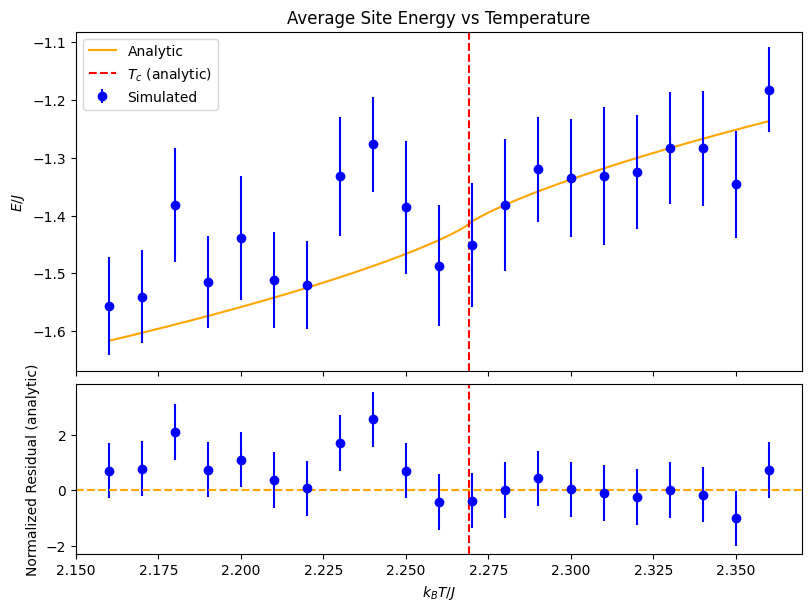

In [22]:
create_T_plot(E_mean, E_std, symbol = 'E/J', name = 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic, fitting_model=None)

Fitting model: power_law_fit
Fitting parameters:
k = 1.21 ± 5.30
T_c = 2.35 ± 1.79
crit_exp = 0.17 ± 2.30
Expected critical exponent: 0.12
Covariance matrix:
[[28.05163972  9.34036482 12.15758757]
 [ 9.34036482  3.22009881  4.09346147]
 [12.15758757  4.09346147  5.28821524]]
Reduced chi squared: 2.08
Probability to exceed: 0.03
Reduced chi squared (analytic): 8.013460559403713


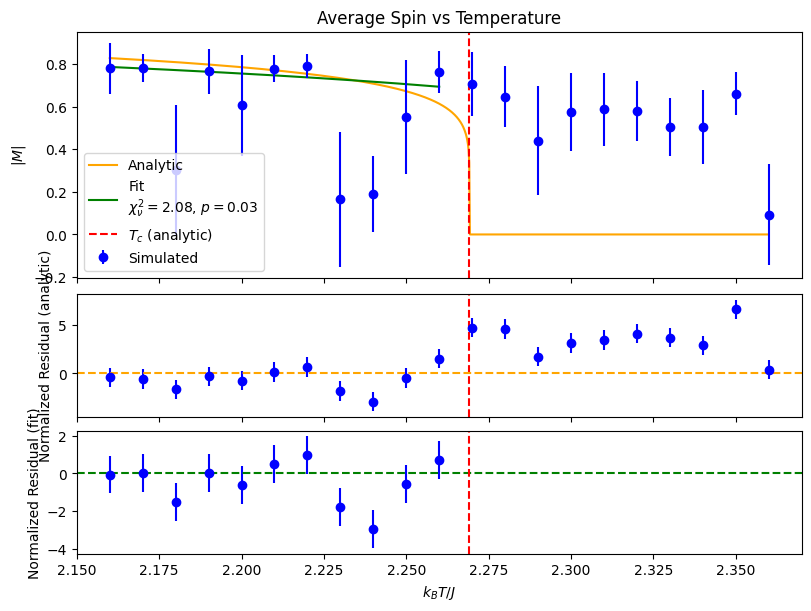

In [23]:
create_T_plot(np.abs(M_mean), M_std, symbol='|M|', name='Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic, from_above = False)

*Proceeding assuming no error (unphysical)
Reduced chi squared (analytic): inf


C:\Users\17757\AppData\Local\Temp\ipykernel_55936\303320491.py:72: RuntimeWarning: divide by zero encountered in divide
  Y_mean_norm_res_analytic = Y_mean_res_analytic / Y_std


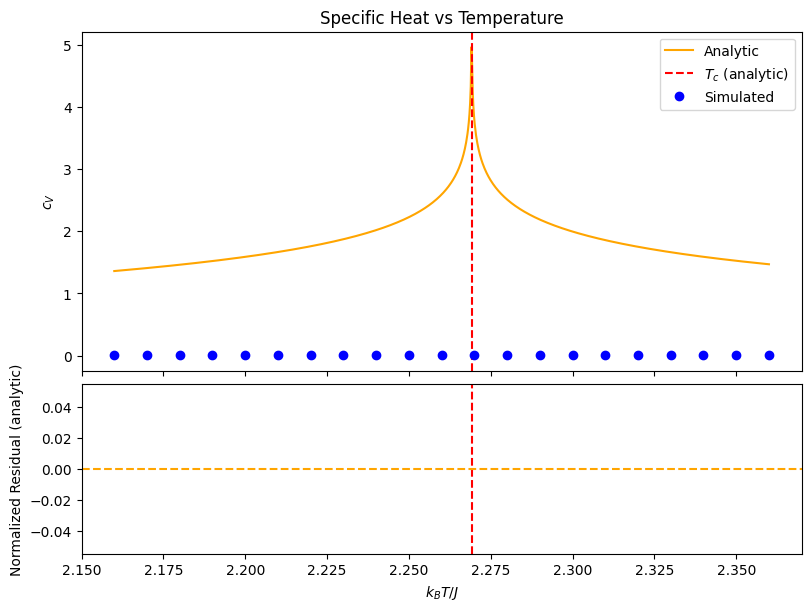

In [24]:
create_T_plot(cV, symbol='c_V', name='Specific Heat', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic, fitting_model=None) #zeros_like forces std to default which is then propagated for ln

# Autocorrelation Single

In [25]:
show_T_scan_at_fixed_d = False
if show_T_scan_at_fixed_d:
    for d, (R_mean, R_std) in enumerate(zip(R_mean_matrix, R_std_matrix), start=1):
        create_T_plot(mean=R_mean, std=R_std, symbol=f'R({d})', name=f'Autocorrelation Function (d = ${d}$)', log_plot = False, expected_crit_exp=0.0, fitting_model=None) #zeros_like forces std to default which is then propagated for ln

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.45 ± 76320597.48
eta = 0.00 ± 0.31
d_c = 14.17 ± 461853656.91
xi = 2.24 ± 128614588.66
Expected critical exponent: 0.25
Covariance matrix:
[[ 5.82483360e+15 -3.00731605e+06 -3.03577465e+16 -9.39757004e+15]
 [-3.00731605e+06  9.53552926e-02  2.00982743e+07  5.55221322e+06]
 [-3.03577465e+16  2.00982743e+07  2.13308800e+17  5.76973893e+16]
 [-9.39757004e+15  5.55221322e+06  5.76973893e+16  1.65417124e+16]]
Reduced chi squared: 0.51
Probability to exceed: 0.88


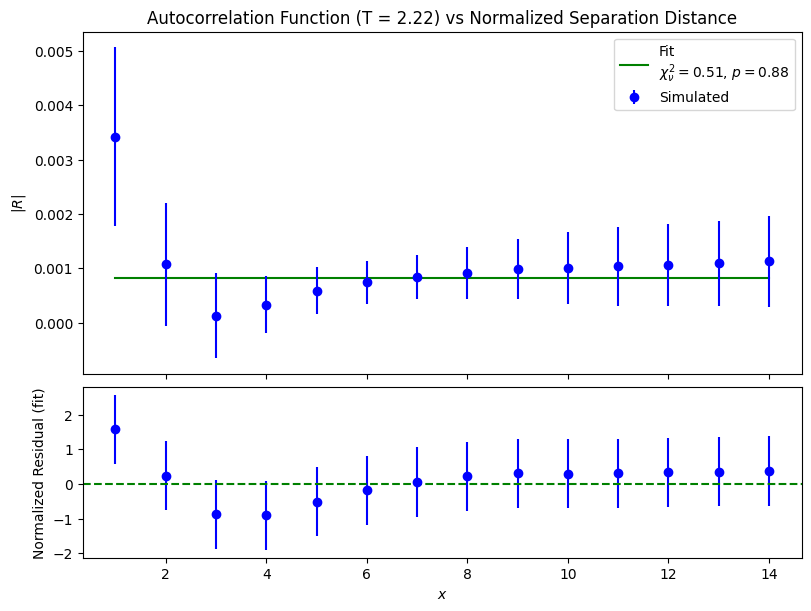

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.05 ± 0.47
d_c = 5.33 ± 3.30
xi = 151823507.96 ± 0.00
Expected critical exponent: 0.25
Covariance matrix:
[[ 4.18787566e-07 -1.13871123e-12 -8.79552718e-04  1.94950577e-19]
 [-1.13871123e-12  2.20485366e-01 -1.22428721e+00  2.68791260e-16]
 [-8.79552718e-04 -1.22428721e+00  1.08891750e+01 -2.39929262e-15]
 [ 1.94950577e-19  2.68791260e-16 -2.39929262e-15  5.28665165e-31]]
Reduced chi squared: 1.87
Probability to exceed: 0.04


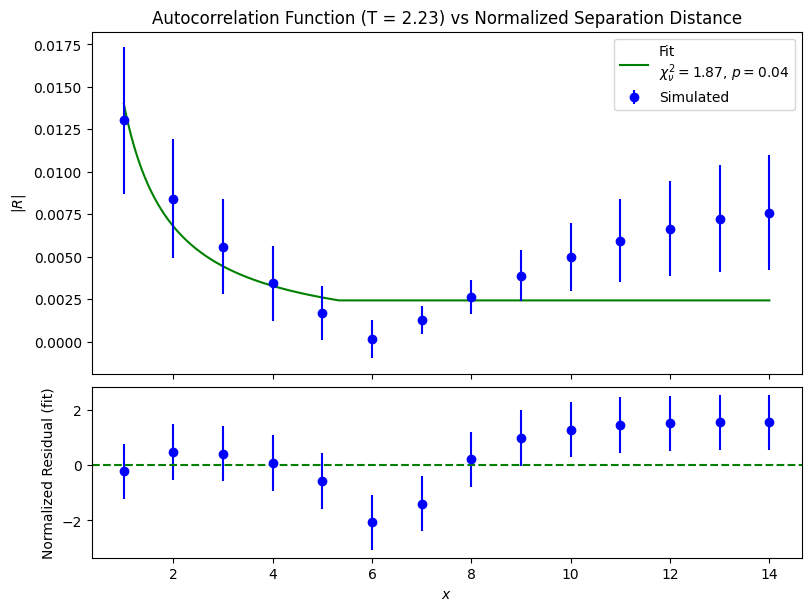

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 0.88 ± 0.36
d_c = 4.86 ± 2.77
xi = 333455024.36 ± 0.00
Expected critical exponent: 0.25
Covariance matrix:
[[ 4.08808059e-07 -6.33166030e-13 -6.39654004e-04 -1.94539491e-18]
 [-6.33166027e-13  1.31189792e-01 -8.60092963e-01 -2.66463513e-15]
 [-6.39654004e-04 -8.60092963e-01  7.66081911e+00  2.36190603e-14]
 [-1.94539491e-18 -2.66463513e-15  2.36190603e-14  7.28246843e-29]]
Reduced chi squared: 3.10
Probability to exceed: 0.00


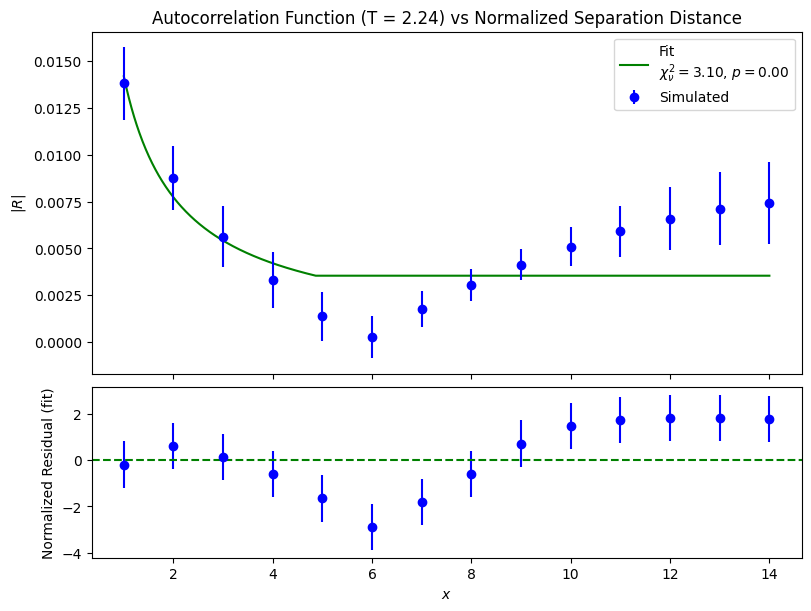

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.20 ± 0.59
d_c = 4.23 ± 2.52
xi = 185897664.16 ± 0.00
Expected critical exponent: 0.25
Covariance matrix:
[[ 1.01360167e-07  5.77879349e-13 -2.33255317e-04 -2.08656848e-18]
 [ 5.77879352e-13  3.50160780e-01 -1.27262208e+00 -1.20414757e-14]
 [-2.33255317e-04 -1.27262208e+00  6.34402523e+00  5.91390028e-14]
 [-2.08656848e-18 -1.20414757e-14  5.91390028e-14  5.51628099e-28]]
Reduced chi squared: 0.56
Probability to exceed: 0.85


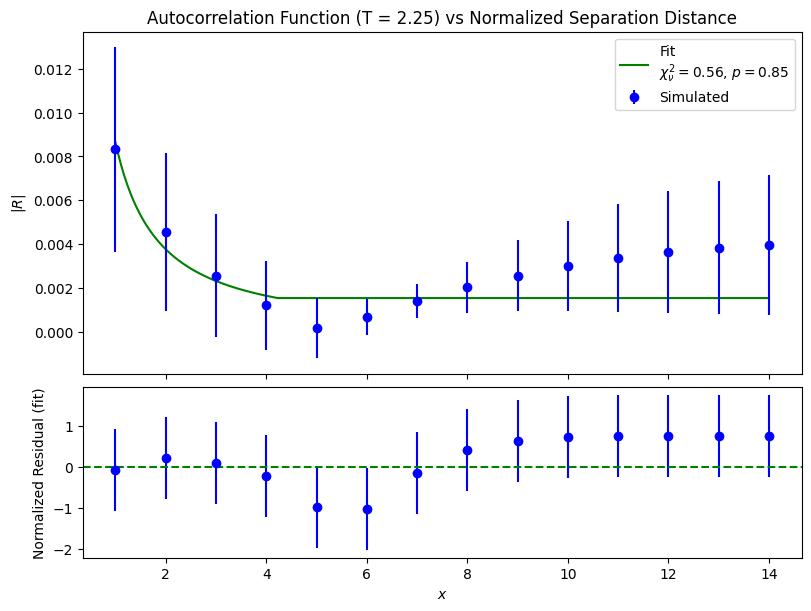

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.89 ± 80937194.30
eta = 0.00 ± 0.36
d_c = 14.43 ± 347776546.98
xi = 2.09 ± 72464575.09
Expected critical exponent: 0.25
Covariance matrix:
[[ 6.55082942e+15  1.75612620e+07 -1.97911304e+16 -5.09818145e+15]
 [ 1.75612620e+07  1.31899132e-01 -3.50743245e+07 -1.10621725e+07]
 [-1.97911304e+16 -3.50743245e+07  1.20948527e+17  2.42619796e+16]
 [-5.09818145e+15 -1.10621725e+07  2.42619796e+16  5.25111464e+15]]
Reduced chi squared: 0.43
Probability to exceed: 0.93


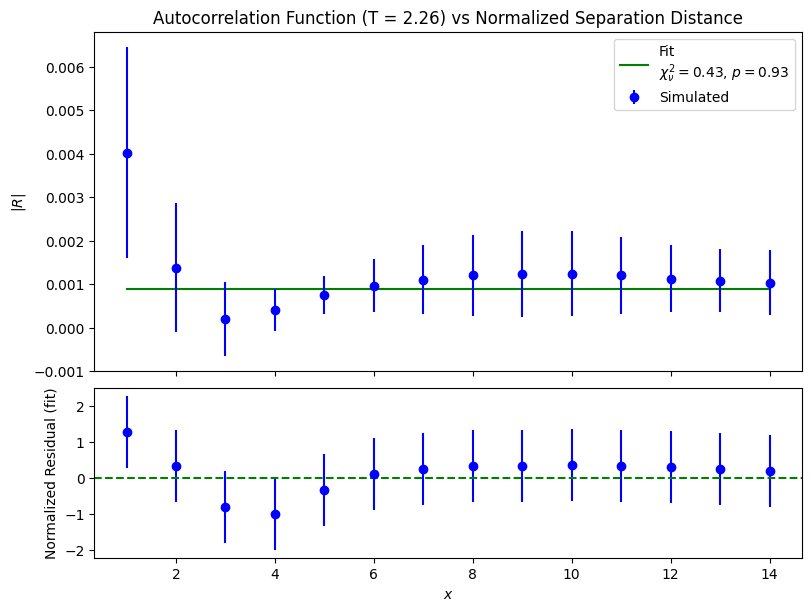

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.37 ± 1.05
d_c = 3.00 ± 2.39
xi = 120.58 ± 849.22
Expected critical exponent: 0.25
Covariance matrix:
[[ 2.73955741e-07  2.24913682e-11 -3.28152075e-04 -4.17850656e-01]
 [ 2.24913682e-11  1.09573317e+00 -2.31177187e+00 -3.91309468e-05]
 [-3.28152075e-04 -2.31177187e+00  5.73536356e+00  4.61958809e+02]
 [-4.17850656e-01 -3.91309468e-05  4.61958809e+02  7.21173431e+05]]
Reduced chi squared: 0.29
Probability to exceed: 0.98


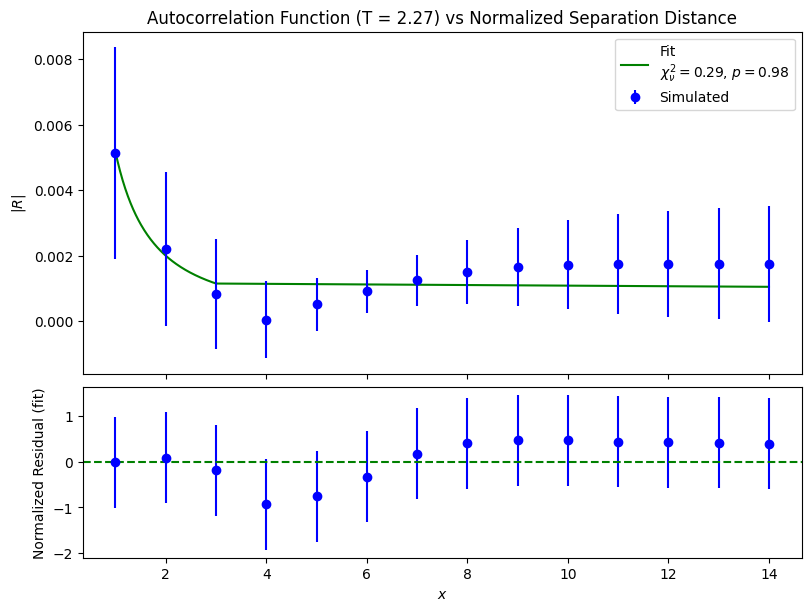

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.40 ± 0.70
d_c = 3.00 ± 1.59
xi = 64.73 ± 267.52
Expected critical exponent: 0.25
Covariance matrix:
[[ 5.31672971e-07  2.57598068e-11 -5.00383058e-04 -1.83067700e-01]
 [ 2.57598068e-11  4.95917752e-01 -8.91382007e-01 -1.00882889e-05]
 [-5.00383058e-04 -8.91382007e-01  2.52348945e+00  1.58773261e+02]
 [-1.83067700e-01 -1.00882889e-05  1.58773261e+02  7.15667102e+04]]
Reduced chi squared: 0.52
Probability to exceed: 0.87


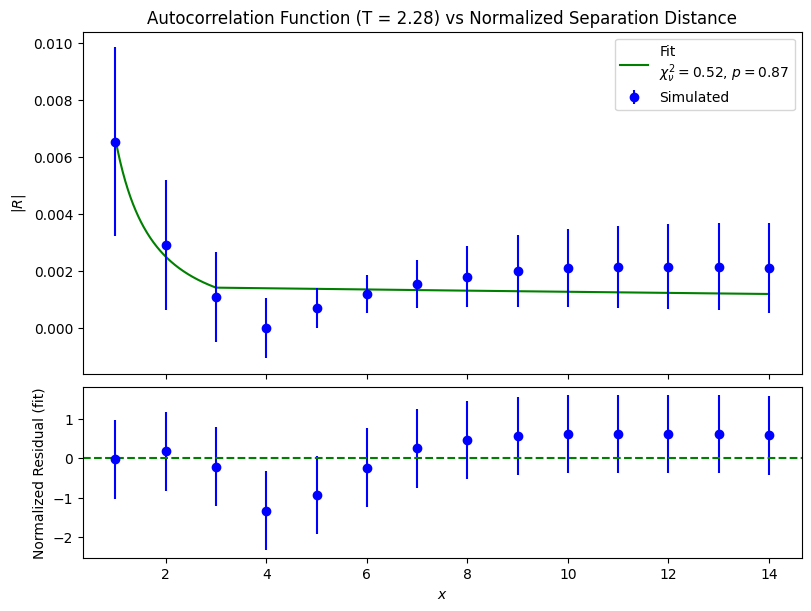

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.13 ± 0.66
d_c = 4.00 ± 3.23
xi = 72.10 ± 464.80
Expected critical exponent: 0.25
Covariance matrix:
[[ 2.57131300e-06  7.27383970e-11 -2.17887272e-03 -7.16369761e-01]
 [ 7.27383970e-11  4.40283414e-01 -1.80085817e+00 -2.17191530e-05]
 [-2.17887272e-03 -1.80085817e+00  1.04190546e+01  5.59803451e+02]
 [-7.16369761e-01 -2.17191530e-05  5.59803451e+02  2.16035687e+05]]
Reduced chi squared: 0.96
Probability to exceed: 0.48


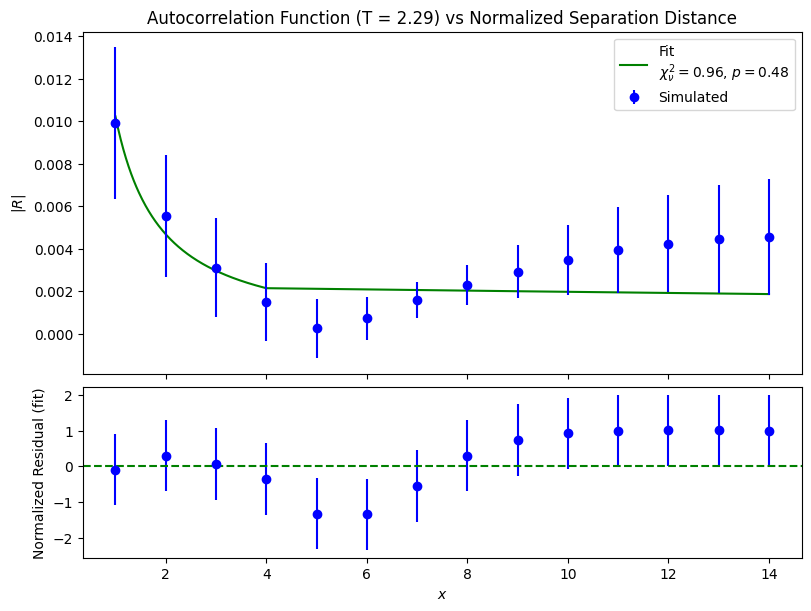

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.30 ± 0.57
d_c = 3.27 ± 1.48
xi = 281664022.39 ± 0.00
Expected critical exponent: 0.25
Covariance matrix:
[[ 6.58349070e-08  2.24446333e-13 -9.78475394e-05 -4.23887867e-19]
 [ 2.24446334e-13  3.22572226e-01 -7.35649821e-01 -3.69077034e-15]
 [-9.78475394e-05 -7.35649821e-01  2.17956401e+00  1.05911963e-14]
 [-4.23887867e-19 -3.69077034e-15  1.05911963e-14  5.16472062e-29]]
Reduced chi squared: 0.56
Probability to exceed: 0.85


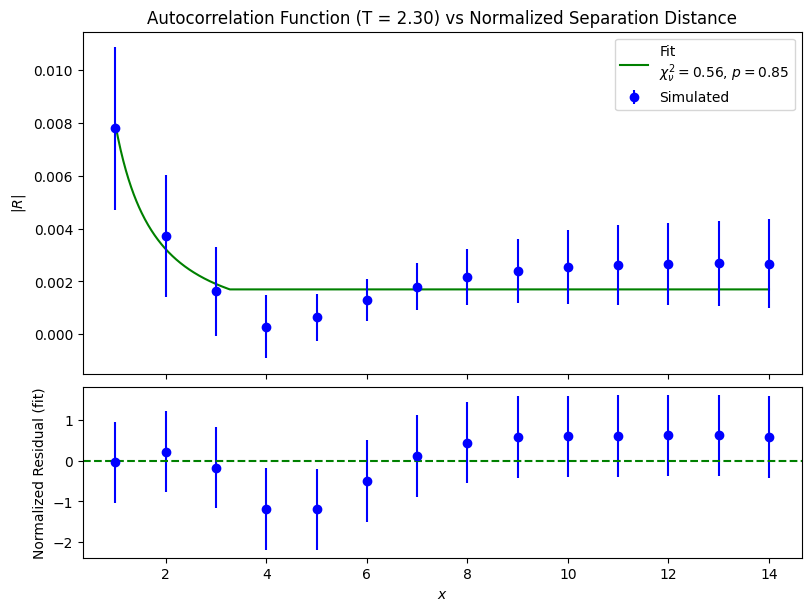

Fitting model: power_law_exp_decay_fit
Fitting parameters:
R_0 = 0.00 ± 0.00
eta = 1.38 ± 0.61
d_c = 3.14 ± 1.35
xi = 284297922.50 ± 0.00
Expected critical exponent: 0.25
Covariance matrix:
[[ 5.78268740e-08 -6.57374605e-14 -8.30726865e-05 -3.38087430e-19]
 [-6.57374615e-14  3.70896939e-01 -7.06586591e-01 -3.52131785e-15]
 [-8.30726865e-05 -7.06586591e-01  1.82271144e+00  8.64807593e-15]
 [-3.38087430e-19 -3.52131785e-15  8.64807593e-15  4.13257541e-29]]
Reduced chi squared: 0.58
Probability to exceed: 0.83


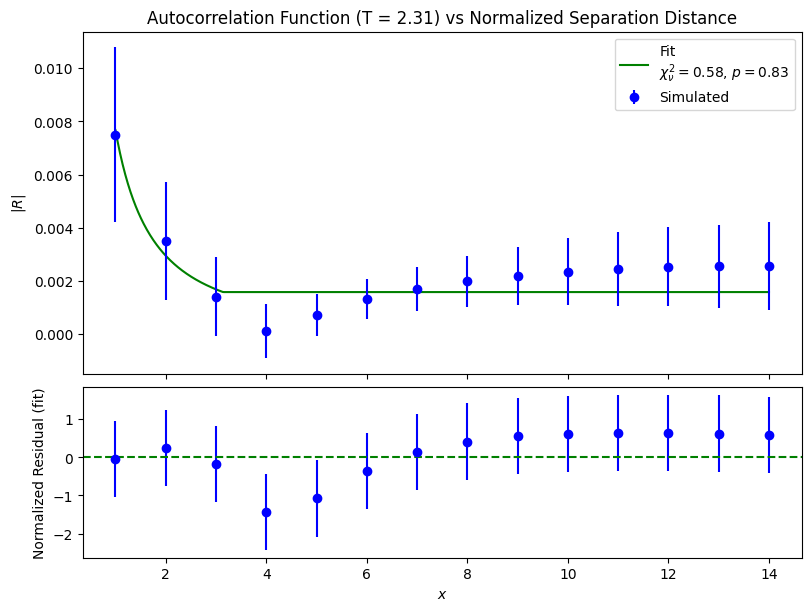

In [26]:
for T_index, (R_mean, R_std) in enumerate(zip(R_mean_matrix.T, R_std_matrix.T)):
    T_current = T[T_index]
    if np.abs(T_current - T_c_analytic) < 0.05:
        create_d_plot(mean=np.abs(R_mean), std=R_std, symbol='|R|', name= f'Autocorrelation Function (T = {T_current:.2f})', log_plot = False) #zeros_like forces std to default which is then propagated for ln

# Multiple CSV Calculations and Plotting

## Pandas to Numpy

In [27]:
#All files in directory
E_means = []
E_stds = []
M_means = []
M_stds = []
R_means = []
R_stds = []
cVs = []
chis = []
for (data,corr) in zip(datas,corrs):
    T, E_mean, E_std, M_mean, M_std= data.T.to_numpy()
    corr_data = corr.T.to_numpy()
    T_corr = corr_data[0]
    assert (T==T_corr).all(), "The correlation CSV is not synced properly with the main CSV"
    R_data = corr_data[1:]
    R_mean, R_std = [R_data[i] for i in range(0,len(R_data),2)], [R_data[i] for i in range(1,len(R_data),2)]
    cV = np.square(E_std)/np.square(T) #In units where k_B = 1
    chi = np.square(M_std)/T #In units where k_B = 1
    E_means.append(E_mean)
    E_stds.append(E_std)
    M_means.append(M_mean)
    M_stds.append(M_std)
    R_means.append(R_mean)
    R_stds.append(R_std)
    cVs.append(cV)
    chis.append(chi)

E_weights = np.array(E_stds)**-2
E_est = np.average(E_means, axis=0, weights=E_weights)
E_est_std = 1/np.sqrt(np.sum(E_weights,axis=0))
M_weights = np.array(M_stds)**-2
M_est = np.average(M_means, axis=0, weights=M_weights)
M_est_std = 1/np.sqrt(np.sum(M_weights,axis=0))
M_abs_est = np.average(np.abs(M_means), axis=0, weights=M_weights)

R_weights = np.array(R_stds)**-2
R_est = np.average(R_means, axis=0, weights=R_weights)
R_est_std = 1/np.sqrt(np.sum(R_weights,axis=0))
cV_mean = np.mean(cVs, axis=0)
cV_std = np.std(cVs, axis=0)/np.sqrt(len(cVs)) #Standard error of the mean
chi_mean = np.mean(chis, axis=0)
chi_std = np.std(chis, axis=0)/np.sqrt(len(chis)) #Standard error of the mean

## Plotting

Fitting model: power_law_fit
Fitting parameters:
k = 0.31 ± 2453746.46
T_c = 2.32 ± 3842.46
crit_exp = 2.89 ± 1987441.72
Expected critical exponent: 1.00
Covariance matrix:
[[ 6.02087168e+12 -1.61071231e+09  4.87399531e+12]
 [-1.61071231e+09  1.47644879e+07 -1.34017222e+09]
 [ 4.87399531e+12 -1.34017222e+09  3.94992459e+12]]
Reduced chi squared: 260.22
Probability to exceed: 0.00
Reduced chi squared (analytic): 0.9305382792596707


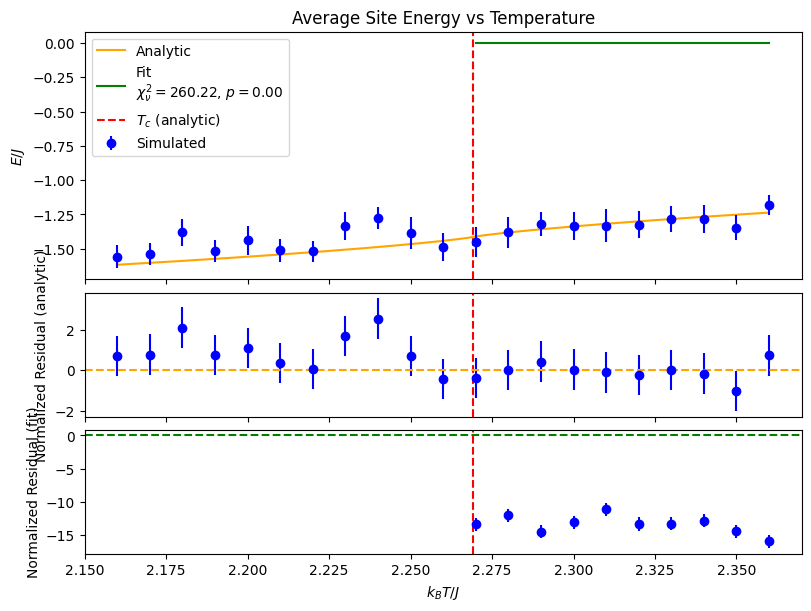

In [28]:
create_T_plot(E_est, E_est_std, 'E/J', 'Average Site Energy', log_plot = False, get_analytic=get_E_mean_analytic)

Fitting model: power_law_fit
Fitting parameters:
k = 0.43 ± 0.25
T_c = 2.27 ± 0.01
crit_exp = -0.07 ± 0.15
Expected critical exponent: 0.12
Covariance matrix:
[[0.06086009 0.00318457 0.03679359]
 [0.00318457 0.00020874 0.00202892]
 [0.03679359 0.00202892 0.02275348]]
Reduced chi squared: 0.79
Probability to exceed: 0.60
Reduced chi squared (analytic): 8.013460559403713


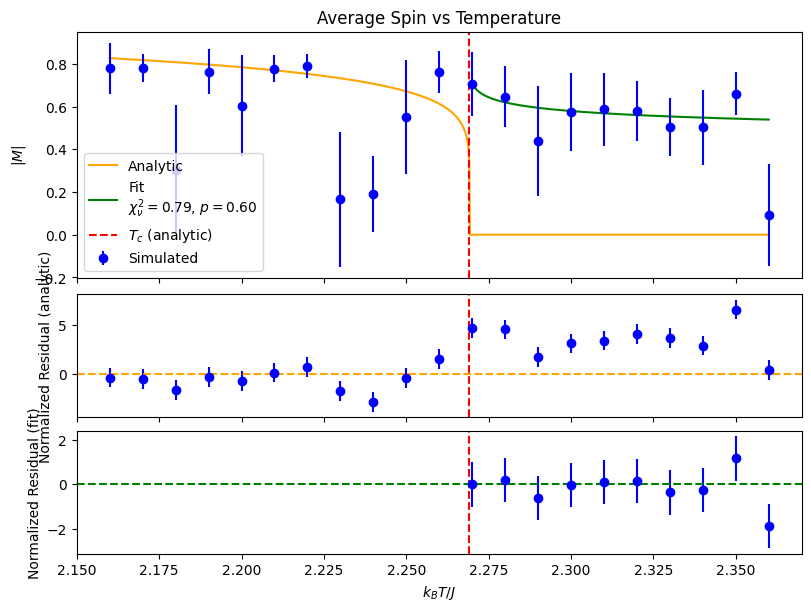

In [29]:
create_T_plot(np.abs(M_abs_est), M_est_std, '|M|', 'Average Spin', log_plot=False, expected_crit_exp=1/8, get_analytic=get_M_abs_analytic)

In [30]:
print(f"cV_mean: {cV_mean}")

cV_mean: [0.0015625  0.00138598 0.00205198 0.00131965 0.00240041 0.00142363
 0.00117987 0.00211082 0.00135855 0.00260044 0.00214072 0.00226361
 0.00252099 0.00157584 0.00195925 0.00266017 0.00182223 0.00170425
 0.00181811 0.00156589 0.00097976]


In [31]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0, get_analytic=get_cV_analytic) #zeros_like forces std to default which is then propagated for ln

*Proceeding assuming no error (unphysical)


c:\Users\17757\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


ValueError: Residuals are not finite in the initial point.

*Proceeding assuming no error (unphysical)


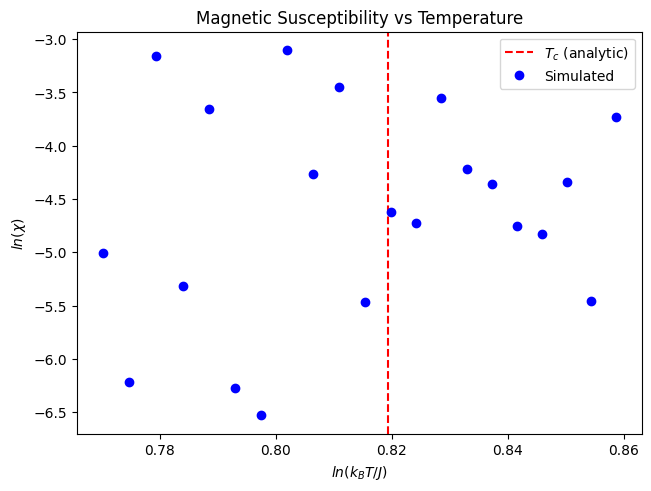

In [ ]:
create_T_plot(chi_mean, chi_std, symbol= r'\chi', name='Magnetic Susceptibility', log_plot = True, expected_crit_exp=-7/4) #zeros_like forces std to default which is then propagated for ln

*Proceeding assuming no error (unphysical)


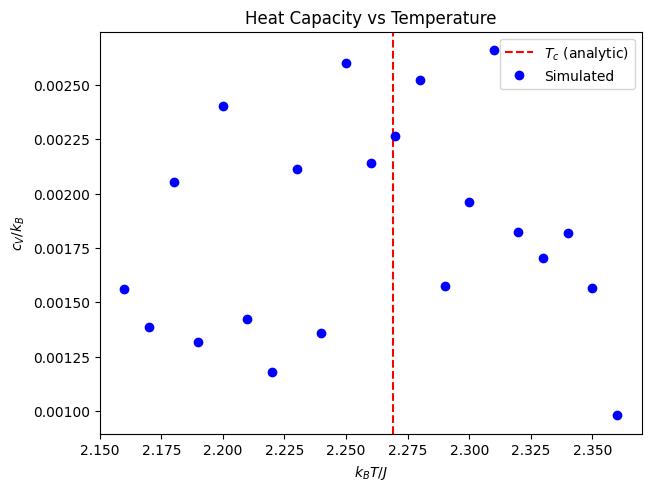

In [ ]:
create_T_plot(cV_mean, cV_std, symbol=r'c_{V}/k_{B}', name='Heat Capacity', log_plot = False, expected_crit_exp=0.0) #zeros_like forces std to default which is then propagated for ln

## Analysis of Burn-In Time and Annealing
 n_transfer = 3000, inp['n_analyze']  = 5000, inp['n_burnin']   =  [0,100,200,300,400,500,600,700,10000]

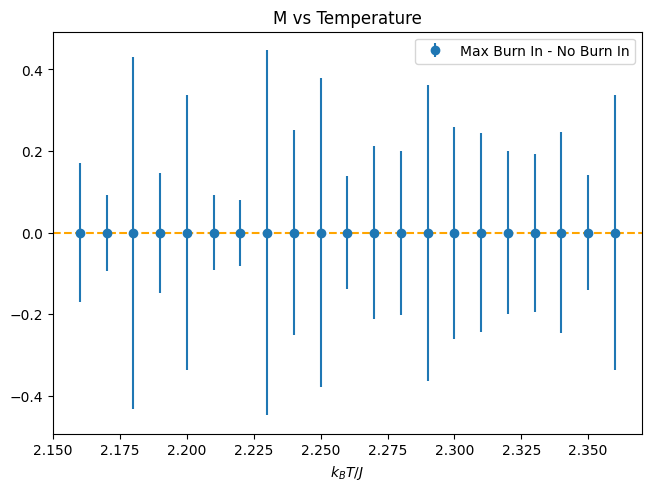

In [ ]:
fig, ax = plt.subplots(1,1, constrained_layout=True, sharex=True)
X_mean_first = np.abs(M_means[0])
X_std_first = M_stds[0]
X_mean_last = np.abs(M_means[-1])
X_std_last = M_stds[-1]
X_mean_diff = X_mean_last - X_mean_first
X_std_diff = np.sqrt(X_std_last**2 + X_std_first**2) #Assuming independent errors
ax.errorbar(x=T, y=X_mean_diff, yerr=X_std_diff, fmt='o', label='Max Burn In - No Burn In')
ax.axhline(0, color='orange', linestyle='--')
ax.set_xlabel('$k_BT / J$')
'''
res_ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')      
ax.plot(using[1], using[5], color='orange', label='Analytic')               
res_ax.set_xlabel(T_label)
res_ax.set_ylabel('Normalized Residual')
res_ax.axhline(0, color='orange', linestyle='--')      
else: #Plotting specific to not having residuals
    fig, ax = plt.subplots(1,1, constrained_layout=True)
    ax.set_xlabel(T_label)
#Plotting common to all variants    
if with_errorbar:
    ax.errorbar(using[0], using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    else:        
    ax.errorbar(using[0], using[3], fmt='o', yerr=None, color='blue', label='Simulated')
ax.set_ylabel(X_label)
ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')    
'''
ax.legend()
ax.set_title('M vs Temperature')
plt.show()